## Final Project Submission

Please fill out:
* Student name: Mohammed Siddiqui
* Student pace: full time
* Scheduled project review date/time: 4/23/2021 11am CST
* Instructor name: Claude Fried
* Blog post URL:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
import xgboost



In [2]:
df =pd.read_csv("./data/train_values.csv")
tr_labels = pd.read_csv("./data/train_labels.csv")


Business Problem:
 * WaterAid has hired us to analyze some waterpoint mapping data they have collected.
 * They would like us to make a model to predict whether a waterpoint is in need of repair.
 * From that model, they would like to know which factures most affect failure rates.
 * Of particular interest is to find out which Local Government Authorities are struggling the most.

# 1. Data Overview

We will be using the Tanzania Waterpoint Mapping data released in 2012.  Dataset is from an active competition on datadriven.org.

Feature descriptions:

* amount_tsh - Total static head (amount water available to waterpoint)
* date_recorded - The date the row was entered
* funder - Who funded the well
* gps_height - Altitude of the well
* installer - Organization that installed the well
* longitude - GPS coordinate
* latitude - GPS coordinate
* wpt_name - Name of the waterpoint if there is one
* num_private -
* basin - Geographic water basin
* subvillage - Geographic location
* region - Geographic location
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
* lga - Geographic location
* ward - Geographic location
* population - Population around the well
* public_meeting - True/False
* recorded_by - Group entering this row of data
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint
* permit - If the waterpoint is permitted
* construction_year - Year the waterpoint was constructed
* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses
* management - How the waterpoint is managed
* management_group - How the waterpoint is managed
* payment - What the water costs
* payment_type - What the water costs
* water_quality - The quality of the water
* quality_group - The quality of the water
* quantity - The quantity of water
* quantity_group - The quantity of water
* source - The source of the water
* source_type - The source of the water
* source_class - The source of the water
* waterpoint_type - The kind of waterpoint
* waterpoint_type_group - The kind of waterpoint

## 1.1 Cursory Look

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

* There are 40 columns here, and many appear to be duplicates

In [4]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


* We can see that a lot of our data appears to be categorical.  Let's see how many columns could be continuous.

In [5]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


*  We have 10 columns that appear to be continuous right now, but that is deceiving.
    * region_code and district_code have numbers, but they are categorical.
    * id and num_private seem to be for internal record keeping.
    * amount_tsh, gps_height, population and construction_year have at least 25% values of 0 which are null
    * I suspect there are zero numbers in latitude and longitude as well

## 1.2 Dealing with the Target Variable

In [6]:
tr_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [7]:
tr_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
tr_labels.status_group.value_counts(normalize=True)


functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

* The majority of the waterpoints are functional, but we need to combine the non functional and functional needs repair

In [9]:
tr_labels['status_group'] = tr_labels['status_group'].map(lambda x: 'needs repair' if x != 'functional' else 'no repair')
df = df.merge(tr_labels, how='left', on='id')
tr_labels.status_group.value_counts(normalize=True)

no repair       0.543081
needs repair    0.456919
Name: status_group, dtype: float64

* This works better and we see that the counts are more even.  We have a binary classification now.

## 1.3 Dropping Excess Columns

In [10]:
df =df.drop([ 'funder', 'gps_height', 'installer', 'wpt_name'
            , 'num_private', 'population', 'public_meeting', 'recorded_by', 'permit',
            'scheme_management', 'scheme_name', 'quantity_group', 'extraction_type',
            'extraction_type_group', 'source', 'payment', 'waterpoint_type' ], axis=1)

* Here, we're dropping some duplicate and problematic columns.
* We can get them back, if necessary.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   basin                  59400 non-null  object 
 6   subvillage             59029 non-null  object 
 7   region                 59400 non-null  object 
 8   region_code            59400 non-null  int64  
 9   district_code          59400 non-null  int64  
 10  lga                    59400 non-null  object 
 11  ward                   59400 non-null  object 
 12  construction_year      59400 non-null  int64  
 13  extraction_type_class  59400 non-null  object 
 14  management             59400 non-null  object 
 15  ma

* Down to 22 categories.  We will eventually have to cut more.

# 2. Data Analysis and Feature Engineering

## 2.1 Taking care of some oddities

In [12]:
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['year_recorded'] = df['date_recorded'].apply(lambda x: x.strftime('%Y')).astype(int)
df['date_recorded'] = df['date_recorded'].apply(lambda x: x.strftime('%Y-%m'))


* Didn't end up using this, but it could be useful if more complete construction_year data comes in.

In [13]:
df.amount_tsh.value_counts(normalize=True)

0.0         0.700993
500.0       0.052222
50.0        0.041616
1000.0      0.025051
20.0        0.024630
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64

* I suspect(confidently) that 0s have been placed in place of the null values
* Simple logic: If you have 64% of the sources functional, you can't have 70% with 0 tsh.
* Ignore category
* Similar issues with the population and construction year.

In [14]:
df.describe()

,id,amount_tsh,longitude,latitude,region_code,district_code,construction_year,year_recorded
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,34.077427,-5.706033e+00,15.297003,5.629747,1300.652475,2011.921667
std,21453.128371,2997.574558,6.567432,2.946019e+00,17.587406,9.633649,951.620547,0.958758
min,0.000000,0.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,2002.000000
25%,18519.750000,0.000000,33.090347,-8.540621e+00,5.000000,2.000000,0.000000,2011.000000
50%,37061.500000,0.000000,34.908743,-5.021597e+00,12.000000,3.000000,1986.000000,2012.000000
75%,55656.500000,20.000000,37.178387,-3.326156e+00,17.000000,5.000000,2004.000000,2013.000000
max,74247.000000,350000.000000,40.345193,-2.000000e-08,99.000000,80.000000,2013.000000,2013.000000


In [15]:
'''def cat_comb(df, category, threshold=5):
    series = pd.value_counts(df[category])
    mask = (series / series.sum() * 100).lt(threshold)
    df[category] = np.where(df[category].isin(series[mask].index),'other', df[category])
    return df[category]
'''

"def cat_comb(df, category, threshold=5):\n    series = pd.value_counts(df[category])\n    mask = (series / series.sum() * 100).lt(threshold)\n    df[category] = np.where(df[category].isin(series[mask].index),'other', df[category])\n    return df[category]\n"

In [16]:
df.basin.value_counts(normalize=True)

Lake Victoria              0.172525
Pangani                    0.150505
Rufiji                     0.134276
Internal                   0.131061
Lake Tanganyika            0.108283
Wami / Ruvu                0.100791
Lake Nyasa                 0.085606
Ruvuma / Southern Coast    0.075640
Lake Rukwa                 0.041313
Name: basin, dtype: float64

* There seem to be some basins combined.  

def hashit(df, column):
    return df[column].apply(lambda x: mmh3.hash(x, seed=42, signed=True)&100)

In [17]:
#df['region'] = hashit(df, 'region')
df.lga.value_counts(normalize=True)

Njombe          0.042138
Arusha Rural    0.021077
Moshi Rural     0.021061
Bariadi         0.019815
Rungwe          0.018620
                  ...   
Moshi Urban     0.001330
Kigoma Urban    0.001195
Arusha Urban    0.001061
Lindi Urban     0.000354
Nyamagana       0.000017
Name: lga, Length: 125, dtype: float64

In [18]:
df['lga'] = df['lga'].apply(lambda x: x.split(" ")[0])
df.lga.value_counts()

Njombe       2503
Moshi        1330
Arusha       1315
Bariadi      1177
Singida      1172
             ... 
Ilemela       142
Mafia         132
Tanga          99
Kinondoni      93
Nyamagana       1
Name: lga, Length: 114, dtype: int64

Single value for Nyamangana is peculiar.  Let's look at it.

In [19]:
df[df['lga'] == 'Nyamagana']

,id,amount_tsh,date_recorded,longitude,latitude,basin,subvillage,region,region_code,district_code,...,management_group,payment_type,water_quality,quality_group,quantity,source_type,source_class,waterpoint_type_group,status_group,year_recorded
3676,16551,0.0,2011-07,32.863271,-2.623808,Lake Victoria,Luchelele Ziwani,Mwanza,19,3,...,user-group,never pay,soft,good,enough,shallow well,groundwater,hand pump,needs repair,2011


* Appears to be in a water rich area where such waterpoints aren't necessary.

sns.histplot(df.status_group)



fig = plt.figure(figsize=(20,15))
ax = sns.scatterplot(data=working[working['construction_year'] != 0], x='longitude', y='latitude', alpha=0.2, hue='construction_year', marker='.')
'''
ax.set(  xlabel='Budget($100 Million)',
         ylabel='Return on Investment(%)', 
         title='Returns by Budget',
         xticks=np.arange(0, 340000000, 50000000), 
         yticks=np.arange(0, 51, 10),  )
'''

plt.xlim([29,41])
plt.ylim([-12,0])
plt.show()

In [20]:
df = df.drop(['id', 'amount_tsh', 'date_recorded', 'year_recorded', 'construction_year', 'management'], axis=1)

* These features don't have much use to us at this point.

## 2.2 Categoricals and Continuous Variables

### 2.2.1 Split

In [21]:
df_cont = df[['latitude', 'longitude']]
df_cat = df.drop(['latitude', 'longitude'], axis=1)

### 2.2.3 Continuous Variables

In [22]:
df_cont = pd.DataFrame(df_cont)

<AxesSubplot:xlabel='latitude', ylabel='Count'>

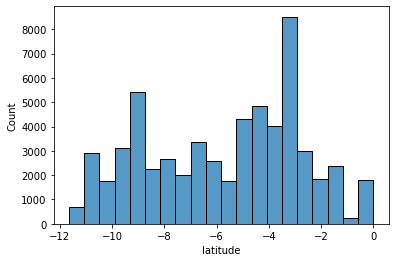

In [23]:
sns.histplot(df_cont.latitude, bins=20)

<AxesSubplot:xlabel='longitude', ylabel='Count'>

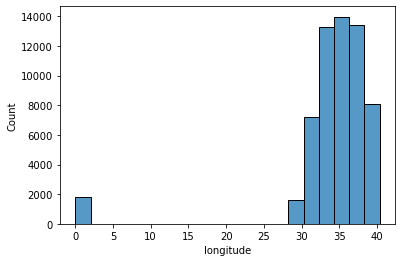

In [24]:
sns.histplot(df_cont.longitude, bins=20)

*  Alright, we got some problematic 0 values which are a placeholder for null
*  Using SimpleImputer with mean or mode would be more problematic.
*  For now, we'll stick with the strategy='ignore' which leaves 0s.

In [25]:
scaler = StandardScaler()

df_cont = scaler.fit_transform(df_cont)
df_cont = pd.DataFrame(df_cont)

### 2.2.2. Categorical Variables

In [26]:
for column in df_cat:
    print(column)
    print (len(df_cat[column].value_counts()))

basin
9
subvillage
19287
region
21
region_code
27
district_code
20
lga
114
ward
2092
extraction_type_class
7
management_group
5
payment_type
7
water_quality
8
quality_group
6
quantity
5
source_type
7
source_class
3
waterpoint_type_group
6
status_group
2


In [27]:
df_cat = df_cat.drop(['subvillage', 'ward', 'source_class', 'water_quality', 'region_code', 'district_code'], axis=1)

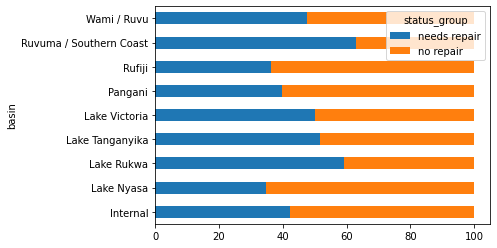

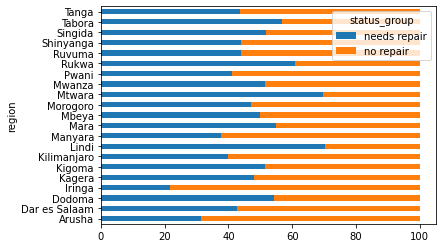

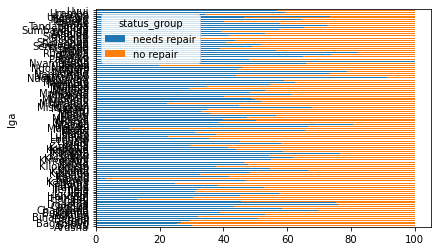

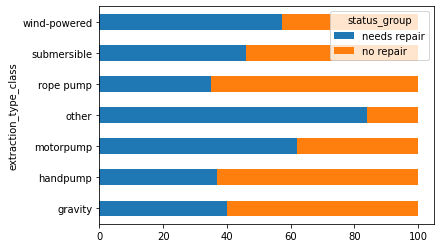

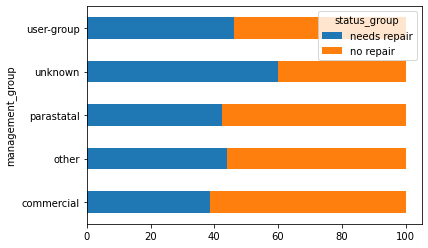

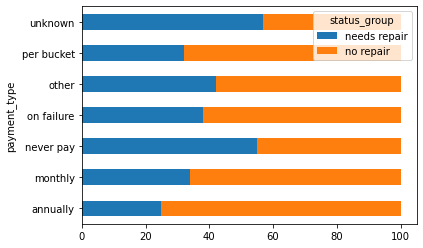

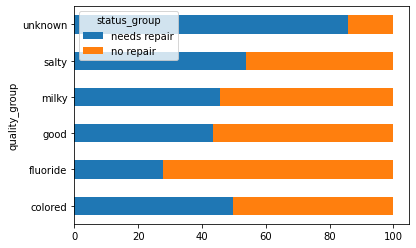

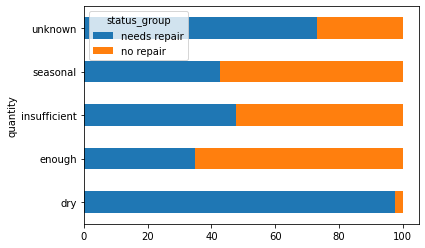

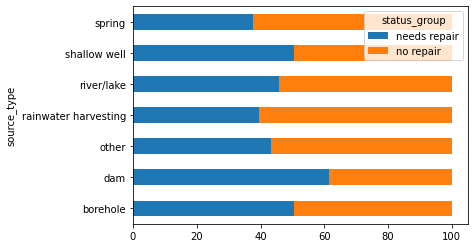

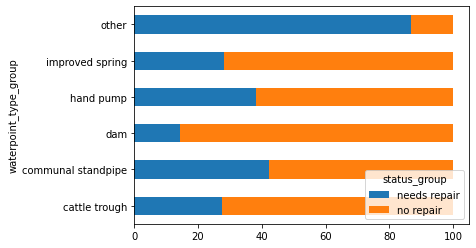

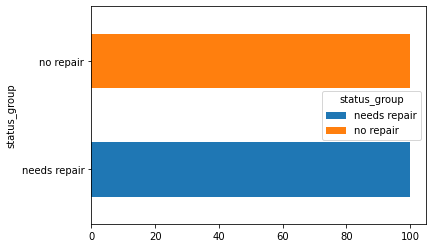

In [28]:
for column in df_cat:
    pd.crosstab(df_cat[column], tr_labels['status_group']
                            ).apply(lambda x: x/x.sum()*100, axis=1
                            ).plot(kind="barh",stacked=True)

In [29]:
for column in df_cat:
    print(df_cat[column].value_counts(normalize=True))

Lake Victoria              0.172525
Pangani                    0.150505
Rufiji                     0.134276
Internal                   0.131061
Lake Tanganyika            0.108283
Wami / Ruvu                0.100791
Lake Nyasa                 0.085606
Ruvuma / Southern Coast    0.075640
Lake Rukwa                 0.041313
Name: basin, dtype: float64
Iringa           0.089125
Shinyanga        0.083872
Mbeya            0.078098
Kilimanjaro      0.073721
Morogoro         0.067441
Arusha           0.056397
Kagera           0.055825
Mwanza           0.052222
Kigoma           0.047407
Ruvuma           0.044444
Pwani            0.044360
Tanga            0.042879
Dodoma           0.037054
Singida          0.035236
Mara             0.033148
Tabora           0.032980
Rukwa            0.030438
Mtwara           0.029125
Manyara          0.026650
Lindi            0.026027
Dar es Salaam    0.013552
Name: region, dtype: float64
Njombe       0.042138
Moshi        0.022391
Arusha       0.022138
Bariadi

* Thints that stand out:
    * Quantity of dry has a huge effect and that's about 10% of wells
    * Payment type of never_pay and unknown have higer repair needs.
        * That's 43% and 14% of all waterpoints
    * LGA has a high amount of variability, so it is very important.

<AxesSubplot:xlabel='lga'>

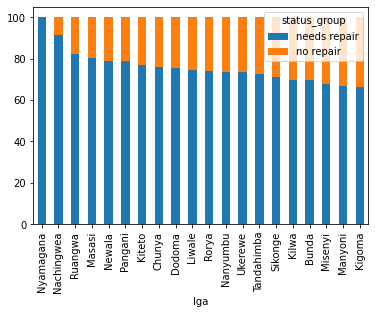

In [30]:
repairc =pd.crosstab(df_cat['lga'], tr_labels['status_group']).apply(lambda x: x/x.sum()*100, axis=1)
repairc =repairc.sort_values(by='needs repair', ascending=False).head(20)
repairc.plot(kind='bar', stacked=True)

*  These are the 20 LGAs that have the highest repair needs by %
*  We notice Nyamagana here.
*  Let's do this for waterpoints where the quantity of water isn't enough.

In [31]:
df_ne = df[df['quantity'] != 'enough']
df_ne.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26214 entries, 1 to 59398
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   longitude              26214 non-null  float64
 1   latitude               26214 non-null  float64
 2   basin                  26214 non-null  object 
 3   subvillage             25942 non-null  object 
 4   region                 26214 non-null  object 
 5   region_code            26214 non-null  int64  
 6   district_code          26214 non-null  int64  
 7   lga                    26214 non-null  object 
 8   ward                   26214 non-null  object 
 9   extraction_type_class  26214 non-null  object 
 10  management_group       26214 non-null  object 
 11  payment_type           26214 non-null  object 
 12  water_quality          26214 non-null  object 
 13  quality_group          26214 non-null  object 
 14  quantity               26214 non-null  object 
 15  so

<AxesSubplot:xlabel='lga'>

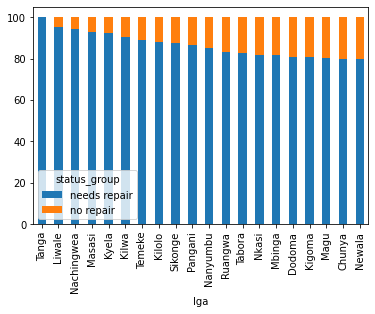

In [32]:
repairc =pd.crosstab(df_ne['lga'], df_ne['status_group']).apply(lambda x: x/x.sum()*100, axis=1)
repairc =repairc.sort_values(by='needs repair', ascending=False).head(20)
repairc.plot(kind='bar', stacked=True)

*  Wow. The LGAs with the highest repair needs are all above 80%

# 3. Prep for Modeling

In [33]:
df_cat = df_cat.drop('status_group', axis=1)
df_cat = pd.get_dummies(df_cat)


* We've got to one-hot encode the categoricals in order to do our models.
* Assigning numerical values to the categories would introduce bias

In [34]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Columns: 187 entries, basin_Internal to waterpoint_type_group_other
dtypes: uint8(187)
memory usage: 11.0 MB


Number of ohe categores jumped to 187, but we have a lot of data points, so it should be fine

In [35]:
df = pd.concat([df_cont, df_cat], axis=1)

In [36]:
le = LabelEncoder()

tr_labels = le.fit_transform(tr_labels.status_group)



In [37]:
X = df
y = tr_labels

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)

In [39]:
X_test.shape

(14850, 189)

# 4. Models

## 4.1 Model 1

Decision Tree Classifier

In [40]:
tree = DecisionTreeClassifier(criterion='gini', 
#                            max_features='log2',
#                            min_samples_leaf=2, 
#                            max_depth=20, 
                            class_weight='balanced')
clf_dt = tree.fit(X_train, y_train)

# Test set predictions
pred = tree.predict(X_test)
# Confusion matrix and classification report

pred_tr = tree.predict(X_train)

print(confusion_matrix(y_test, pred))

print(classification_report(y_test, pred))

print("Training Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_train, pred_tr) * 100))
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))


[[5148 1647]
 [1680 6375]]
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      6795
           1       0.79      0.79      0.79      8055

    accuracy                           0.78     14850
   macro avg       0.77      0.77      0.77     14850
weighted avg       0.78      0.78      0.78     14850

Training Accuracy for Decision Tree Classifier: 99.4%
Testing Accuracy for Decision Tree Classifier: 77.6%


* Testing accuracy isn't bad, but we are definitely overfit.

In [41]:
tree.feature_importances_
df.columns
feature_imp = pd.DataFrame({'feature': df.columns, 'importance': tree.feature_importances_*100})
feature_imp.sort_values(by=['importance'], ascending=False).head(20)

,feature,importance
0,0,26.118872
1,1,25.571857
171,quantity_dry,12.059091
188,waterpoint_type_group_other,6.908221
14,region_Iringa,1.908849
160,payment_type_never pay,1.305752
172,quantity_enough,0.865041
151,extraction_type_class_submersible,0.836306
180,source_type_river/lake,0.753602
157,management_group_user-group,0.720756


* Latitude and Longitude are being overrepresented here because they are continuous
* Dry quantity and never pay show up as issues.

,feature,importance
3,lga,12.163934
10,source_type,11.366511
6,payment_type,10.771261
2,district_code,10.177237
4,extraction_type_class,10.063785
9,quantity,9.341607
1,region_code,9.285020
0,region,8.750916
5,management_group,4.486133
12,waterpoint_type_group,3.955747


* The above is for the hash trick being kept for reference

## 4.2 Model 2

Random Forest Classifier

### 4.2.1 No changes to hyperparameters

In [42]:
clf = RandomForestClassifier().fit(X_train, y_train)

pred = clf.predict(X_test)

# Test set predictions
pred_tr = clf.predict(X_train)
# Confusion matrix and classification report

print("Training Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_train, pred_tr)* 100))

print("Testing Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, pred)* 100))

print(confusion_matrix(y_test, pred))

print(classification_report(y_test, pred))

Training Accuracy for Random Forest Classifier: 99.41%
Testing Accuracy for Random Forest Classifier: 80.26%
[[5200 1595]
 [1336 6719]]
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      6795
           1       0.81      0.83      0.82      8055

    accuracy                           0.80     14850
   macro avg       0.80      0.80      0.80     14850
weighted avg       0.80      0.80      0.80     14850



*  The accuracy improved, but we are still overfit.

### 4.2.2. Manual tweaks to hyperparameters

In [44]:
clf = RandomForestClassifier( n_estimators=200, 
                            max_samples=0.25,
                            max_depth=20,  
                            class_weight='balanced'
                            ).fit(X_train, y_train)

pred = clf.predict(X_test)

# Test set predictions
pred_tr = clf.predict(X_train)
# Confusion matrix and classification report

print("Training Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_train, pred_tr)* 100))

print("Testing Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, pred)* 100))

print(confusion_matrix(y_test, pred))

print(classification_report(y_test, pred))

Training Accuracy for Random Forest Classifier: 84.64%
Testing Accuracy for Random Forest Classifier: 80.67%
[[4837 1958]
 [ 913 7142]]
              precision    recall  f1-score   support

           0       0.84      0.71      0.77      6795
           1       0.78      0.89      0.83      8055

    accuracy                           0.81     14850
   macro avg       0.81      0.80      0.80     14850
weighted avg       0.81      0.81      0.80     14850



*  Overfitting issue mostly fixed.  Testing accuracy went up.
*  Precision of 0.84 for needs repair isn't bad.

In [45]:
feature_imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_*100})
feature_imp.sort_values(by=['importance'], ascending=False).head(20)

,feature,importance
1,1,14.495148
0,0,13.950006
171,quantity_dry,10.477051
172,quantity_enough,4.862883
188,waterpoint_type_group_other,4.621395
149,extraction_type_class_other,3.956431
160,payment_type_never pay,2.569109
173,quantity_insufficient,1.870303
163,payment_type_per bucket,1.403426
147,extraction_type_class_handpump,1.371852


Based on these, let's try to see what's important.
* Quantity is very important, especially dry and enough.
* Only use 1 geographic column. Region, especially Kigoma and Iringa shows up here.
    * I still like lga more just because of the discrepancies seen in the graph.
    * This also fits our business problem most.
* Extraction Type: Other and Gravity
* Waterpoint Type: Other and communal standpipe
* Payment Type: Never pay, per bucket, monthly, unknown
* Source Type: Borehole, shallow well

### 4.2.3 RFC with Grid Search

In [46]:


rfg = RandomForestClassifier()

param_grid ={'bootstrap': [True],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 400],
    'class_weight': ['balanced']
    }

rf_grid = GridSearchCV(estimator = rfg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [47]:
#rf_grid.fit(X_train, y_train)

#rf_grid.best_params_

* The parameters below were given by the grid search.
* I've commented out the fit just because it takes 15 minutes each time.

In [48]:
rfg = RandomForestClassifier( n_estimators=200, 
                            max_samples=0.25,
                            min_samples_leaf= 2,
                            min_samples_split=2,
                            max_depth=40,  
                            class_weight='balanced'
                            ).fit(X_train, y_train)

pred = rfg.predict(X_test)

# Test set predictions
pred_tr = rfg.predict(X_train)
# Confusion matrix and classification report

print("Training Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_train, pred_tr)* 100))

print("Testing Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, pred)* 100))

print(confusion_matrix(y_test, pred))

print(classification_report(y_test, pred))

Training Accuracy for Random Forest Classifier: 83.57%
Testing Accuracy for Random Forest Classifier: 80.26%
[[5012 1783]
 [1149 6906]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      6795
           1       0.79      0.86      0.82      8055

    accuracy                           0.80     14850
   macro avg       0.80      0.80      0.80     14850
weighted avg       0.80      0.80      0.80     14850



*  This is very similar to the previous model with a slightly worse accuracy.
*  Slight overfit is still there
*  Precision went down to 81 for the needs repair
*  Choosing between the previous 2 models is tough, so we will wait for the CV scores.

## 4.3 Gradient Boosting

In [49]:
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train, y_train)
pred = xgb_clf.predict(X_test)
pred_tr = xgb_clf.predict(X_train)



print("Training Accuracy for Gradient Boost: {:.4}%".format(accuracy_score(y_train, pred_tr)* 100))

print("Testing Accuracy for Gradient Boost: {:.4}%".format(accuracy_score(y_test, pred)* 100))

print(confusion_matrix(y_test, pred))

print(classification_report(y_test, pred))

Training Accuracy for Gradient Boost: 82.35%
Testing Accuracy for Gradient Boost: 79.64%
[[4737 2058]
 [ 965 7090]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      6795
           1       0.78      0.88      0.82      8055

    accuracy                           0.80     14850
   macro avg       0.80      0.79      0.79     14850
weighted avg       0.80      0.80      0.79     14850



* I had high hopes for this, but we're getting more success with RFC

# 5. Model Selection

In [62]:
cv_model_1  =cross_val_score(tree, X_test, y_test, cv=5, estimator='accuracy').mean()
cv_model_22 =cross_val_score(clf, X_test, y_test, cv=5, estimator='accuracy').mean()
cv_model_23 =cross_val_score(rfg, X_test, y_test, cv=5, estimator='accuracy').mean()
cv_model_3  =cross_val_score(xgb_clf, X_test, y_test, cv=5, estimator='accuracy').mean()

In [63]:
print(f'Cross Value for Decision Tree: {cv_model_1*100:.1f}%')
print(f'Cross Value for Random Forest Mine: {cv_model_22*100:.1f}%')
print(f'Cross Value for Random Forest GridSearch: {cv_model_23*100:.1f}%')
print(f'Cross Value for Xgboost: {cv_model_3*100:.1f}%')

Cross Value for Decision Tree: 74.4%
Cross Value for Random Forest Mine: 78.4%
Cross Value for Random Forest GridSearch: 77.8%
Cross Value for Xgboost: 77.7%


* Based on these, I will go with Model 2.2 which is the Random Forest with my hyperparameters.